### Single-Layer Perceptron
Perhaps the simplest neural network we can define for binary classification is the single-layer perceptron. Given an input, the output neuron fires (produces an output of 1) only if the data point belongs to the target class. Otherwise, it does not fire (it produces an output of -1). The network looks something like this:

<img src="images/sl_perceptron.png" >

Instead of using a linear activation function like in linear regression, we instead use a sign function. Recall the definition of the sign function:

$$
\mbox{sign}(\mathbf{w}^T\mathbf{x}_i) = 
\begin{cases}
1 &\mbox{if }\mathbf{w}^T\mathbf{x}_i > 0 \\
0 &\mbox{if }\mathbf{w}^T\mathbf{x}_i = 0 \\
-1 &\mbox{if }\mathbf{w}^T\mathbf{x}_i < 0
\end{cases}
$$

In this, we are computing the dot product of an example with our weight vector. Points with positive projections will be given a label of 1 and points with negative projections will be given a label of -1. Consequently, our decision boundary will be perpendicular to our weight vector. Why? Consider a 2-dimensional decision problem. The decision boundary is the line where it is equally probable that a point on that line belongs to either class, i.e. $ h(\mathbf{x}_i, \mathbf{w}) = \mbox{sign}(\mathbf{w}^T\mathbf{x}_i) = 0 $, or $ \mathbf{w}^T\mathbf{x}_i = 0 $. Then we have:

$$ \begin{align}
\mathbf{w}^T\mathbf{x}_i =& 0\\
w_1+w_2x_i^{(2)} + w_3x_i^{(3)} =& 0\\
x_i^{(3)} =& -\frac{w_2}{w_3}x_i^{(2)} -\frac{w_1}{w_3}
\end{align} $$

In this case, $ x_i^{(1)} $ is our bias value and is always equal to 1, $ x_i^{(2)}  $ is "$ x $" in the cartesian plane and $ x_i^{(3)} $ is "$ y $." The slope of our weight vector in the cartesian plane is $ \frac{w_3}{w_2} $ (they "$ y $" component of $ \mathbf{w} $ is $ w_3 $, and the "$ x $" component is $ w_2 $), while the slope of the decision boundary is $ -\frac{w_2}{w_3} $ (thus making them perpendicular). Graphically, this looks something like this:


<img src="images/linear_db.png">


The problem we now face is that the step function is not continuously differentiable, and we cannot use standard gradient descent to learn the weights. Therefore, we will use the appropriately-named perceptron algorithm . This algorithm is an online method used to successively update the weights defining a linear boundary only if that boundary does not classify a training point correctly.  The algorithm is as follows: 
Initialize the weight vector $ \mathbf{w} $ to all zeros.
Repeat the following:
      
For each training example $ \mathbf{x}_i $: 
        	
 1. If $ h(\mathbf{x}_i, \mathbf{w}) \neq y_i $, then update the weights with $ \mathbf{w}' = \mathbf{w}+\eta y_i\mathbf{x}_i $ Here, $ \eta $ is the step size.


 2. If the stopping condition $ \frac{1}{N} \sum_{j=0}^M |w_j' - w_j| < \delta $ is reached, then accept $  \mathbf{w} $ as the final weight vector ($ M $ in this case is the number of features in the dataset).


If our problem is linearly separable, the perceptron algorithm is guaranteed to converge. Therefore, at the algorithm's termination, we will end up with a linear decision boundary defined by $ \mathbf{w} $. However, this decision boundary is not guaranteed to be a maximum margin hyperplane as in the case of SVMs.
 
Finally, if we want to predict the label $ \hat{y}_i $ of a test point $ \mathbf{x}_i $, we use $ \hat{y}_i = \mbox{sign}(\mathbf{w}^T\mathbf{x}_i) $.While it is not strictly necessary to define a neural network to use the perceptron algorithm, this is a good first step towards single-layer classification.

### Classification with a sigmoid (softmax) activation function
Instead of an all-or-nothing classifier (like the sign function), it is helpful to come up with some way to measure the probability of assignment, that is $ P( Y = y_i\ |\ X = \mathbf{x}_i, \mathbf{w} ) $. If we can calculate this likelihood, we can use as a confidence measure of our predictions.

Instead of using a sign activation function, we can instead use a sigmoid (usually called softmax in the neural net literature) to output a probability: 

$$ P(Y = y\ |\ X = \mathbf{x}_i, \mathbf{w}) = \frac{1}{1+\exp\left(-y\mathbf{w}^T\mathbf{x}_i\right)}$$

But how do we assign a class label when given only a probability? We can simply "clamp" the probability using a sign function, so that any $ P(Y = 1\ |\ \mathbf{x}_i, \mathbf{w}) \geq 0.5$ is assigned a class label of 1, and any probability less than 0.5 is given a class label of -1. Our simple network now looks something like the following: 



<img src="images/linear_sigmoid.png">



Luckily for us, this network function is identical to the likelihood used by logistic regression. Because the sigmoid is differentiable, we can use standard gradient acent to train the weights instead of the perceptron algorithm. For a derivation of the gradient for logistic regression, see the Appendix.ImplementationTo implement this theory, we'll be learning a set of weights that classify two groups of 2D data using both the perceptron algorithm and gradient descent. Let's start out by defining our 2D data (you can find this code in ann_linear_2D_classification_perceptron.py): 


## Implementation

In [83]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as data
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools

from argparse import Namespace
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

x = np.array([[0, 0],[0, 1],[1, 0], [1, 1]], dtype=np.float32)
y = np.array([[0], [0], [0], [1]], dtype=np.float32)
lr = 1e-2
max_iter = 1000

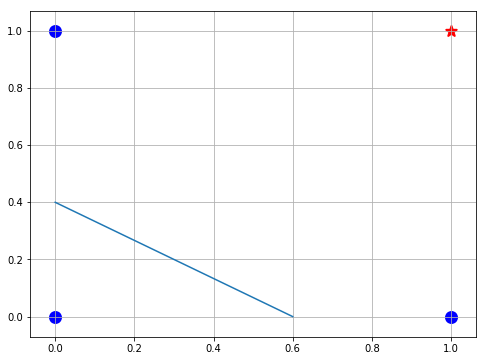

In [2]:
plt.figure(figsize=(8, 6))
plt.scatter(x[0,0], x[0, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[1,0], x[1, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[2,0], x[2, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[3,0], x[3, 1], s=120, c='red', marker='*', linewidths=2)
plt.plot([0.6, 0],[0, 0.4])
plt.grid(True)
plt.show()

In [3]:
class Perceptron(object):
    """Implements a perceptron network"""
    def __init__(self, input_size, lr=1, epochs=100):
        self.W = np.zeros(input_size+1)
        self.epochs = epochs
        self.lr = lr
    
    def activation_fn(self, x):
        return 1 if x >= 0 else 0
 
    def predict(self, x):
        z = self.W.T.dot(x)
        a = self.activation_fn(z)
        return a
 
    def fit(self, X, d):
        for _ in range(self.epochs):
            for i in range(d.shape[0]):
                x = np.insert(X[i], 0, 1)
                y = self.predict(x)
                e = d[i] - y
                self.W = self.W + self.lr * e * x
                

perceptron = Perceptron(input_size=2)
perceptron.fit(x, y)
print(perceptron.W)

print(perceptron.predict(np.insert(x[3], 0, 1)))

[-3.  2.  1.]
1


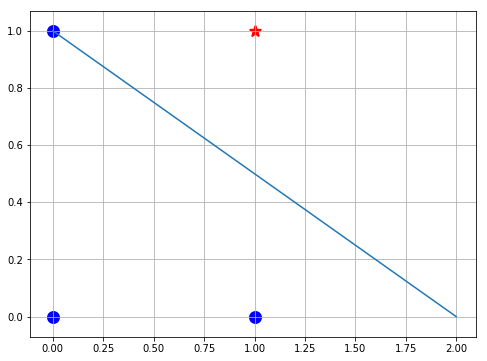

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(x[0,0], x[0, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[1,0], x[1, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[2,0], x[2, 1], s=120, c='blue', marker='o', linewidths=2)
plt.scatter(x[3,0], x[3, 1], s=120, c='red', marker='*', linewidths=2)
plt.plot([2, 0],[0, 1])
plt.grid(True)
plt.show()

### Multi-Layer Perceptron
Multiclass classification using a linear neural network is a fairly simple extension of the binary classification setup. You may think that instead of outputting 0/1 from our second layer node, we could output 0, 1, ..., $K-1$. However, this is not the case . Our labels are not necessarily linear, and halfway between $\hat{y}=0$ and $\hat{y}=2$ is not necessarily $\hat{y}=1$. They are in fact categorical, and we use $k \in \{0, 1, \ldots, K\}$ out of computational convenience.

Consider instead representing a label using a binary vector of length $K$. Having a 1 in position $k$ corresponds to a label of $k$. Then, we can extend our linear network (with a sigmoid activation at the output) to learn how to output this vector. It would look something like the following:

<img src="images/linear_multiclass.png">


Note that instead of $|\mathbf{w}| = M$ (where $M$ is the number of features), we instead have $|\mathbf{w}| = MK$. So in this figure, we have $K=3$ classes, and 3 features, giving us 9 weights in total. In fact, this is the neural network view of multinomial logistic regression. Recall the previous likelihood used in binary logistic regression: $$ P(Y = y\ |\ X = \mathbf{x}_i, \mathbf{w}) = \frac{1}{1+\exp\left(-y\mathbf{w}^T\mathbf{x}_i\right)}$$ To extend this to $K$ classes, we use the following likelihood: $$ P(Y = k\ |\ X = \mathbf{x}_i, \mathbf{w}) = \frac{\exp(\mathbf{w}_k^T\mathbf{x}_i)}{\sum_{k'}^K\exp\left(\mathbf{w}_{k'}^T\mathbf{x}_i\right)}$$ The key difference is that there are now $K$ sets of $M$ weights, one for each label. These are specified when determining the likelihood for a particular $k$. By using this formalism, we ensure that the values produced by the output nodes forms a valid probability distribution, as we are normalizing the likelihood by summing over all values of $k$. 

Our training routine is exactly the same as in Part 2, except that the gradient of the multinomial logistic regression objective is slightly different: $$ \nabla_{\mathbf{w}_k}\ell(\mathbf{w}) = \frac{1}{N} \sum_i^N\left(\mathbf{x_i}(1-P(Y = y_i\ |\ X = \mathbf{x}_i, \mathbf{w})\right) $$ See the Appendix for a full derivation.

### Backpropagation

Up until now, we haven't utilized any of the expressive non-linear power of neural networks - all of our simple one layer models corresponded to a linear model such as multinomial logistic regression. These one-layer models had a simple derivative. We only had one set of weights the fed directly to our output, and it was easy to compute the derivative with respect to these weights. However, what happens when we want to use a deeper model? What happens when we start stacking layers? 

<img src="images/back_prop.png">

No longer is there a linear relation in between a change in the weights and a change of the target. Any perturbation at a particular layer will be further transformed in successive layers. So, then, how do we compute the gradient for all weights in our network? This is  where we use the backpropagation algorithm.

Backpropagation, at its core, simply consists of repeatedly applying the chain rule through all of the possible paths in our network. However, there are an exponential number of directed paths from the input to the output. Backpropagation's real power arises in the form of a dynamic programming algorithm, where we reuse intermediate results to calculate the gradient. We transmit intermediate errors backwards through a network, thus leading to the name backpropagation. In fact, backpropagation is closely related to forward propagation, but instead of propagating the inputs forward through the network, we propagate the error backwards.

Most explanations of backpropagation start directly with a general theoretical derivation, but I’ve found that computing the gradients by hand naturally leads to the backpropagation algorithm itself, and that’s what I’ll be doing in this blog post. This is a lengthy section, but I feel that this is the best way to learn how backpropagation works.

I’ll start with a simple one-path network, and then move on to a network with multiple units per layer. Finally, I’ll derive the general backpropagation algorithm. Code for the backpropagation algorithm will be included in my next installment, where I derive the matrix form of the algorithm.

#### Deriving the base rules of backpropagation
Remember that our ultimate goal in training a neural network is to find the gradient of each weight with respect to the output: $$\begin{align} \frac{\partial E}{\partial w_{i\rightarrow j}} \end{align}$$ We do this so that we can update the weights incrementally using stochastic gradient descent: $$\begin{align*} w_{i\rightarrow j} =& w_{i\rightarrow j} -\eta \frac{\partial E}{\partial w_{i\rightarrow j}} \end{align*}$$
For a single unit in a general network, we can have several cases: the unit may have only one input and one output (case 1), the unit may have multiple inputs (case 2), or the unit may have multiple outputs (case 3). Technically there is a fourth case: a unit may have multiple inputs and outputs. But as we will see, the multiple input case and the multiple output case are independent, and we can simply combine the rules we learn for case 2 and case 3 for this case.

I will go over each of this cases in turn with relatively simple multilayer networks, and along the way will derive some general rules for backpropagation.  At the end, we can combine all of these rules into a single grand unified backpropagation algorithm for arbitrary networks.

##### Case 1: Single input and single output
Suppose we have the following network:

<img src="images/single_out.png">


We can explicitly write out the values of each of variable in this network: 

$$ \begin{align} s_j =&\ w_1\cdot x_i\\ z_j =&\ \sigma(in_j) = \sigma(w_1\cdot x_i)\\ s_k =&\ w_2\cdot z_j\\ z_k =&\ \sigma(in_k) = \sigma(w_2\cdot\sigma(w_1\cdot x_i))\\ s_o =&\ w_3\cdot z_k\\ \hat{y}_i =&\ in_o = w_3\cdot\sigma(w_2\cdot\sigma(w_1\cdot x_i))\\ E =&\ \frac{1}{2}(\hat{y}_i - y_i)^2 = \frac{1}{2}(w_3\cdot\sigma(w_2\cdot\sigma(w_1\cdot x_i)) - y_i)^2 \end{align} $$ 

For this simple example, it's easy to find all of the derivatives by hand. In fact, let's do that now. I am going to color code certain parts of the derivation, and see if you can deduce a pattern that we might exploit in an iterative algorithm. First, let's find the derivative for $w_{k\rightarrow o}$ (remember that $\hat{y} = w_{k\rightarrow o}z_k$, as our output is a linear unit): 

$$ \begin{align} \frac{\partial E}{\partial w_{k\rightarrow o}} =&\ \frac{\partial}{\partial w_{k\rightarrow o}} \frac{1}{2}(\hat{y}_i - y_i)^2\\ =&\ \frac{\partial}{\partial w_{k\rightarrow o}} \frac{1}{2}(w_{k\rightarrow o}\cdot z_k - y_i)^2\\ =&\ (w_{k\rightarrow o}\cdot z_k - y_i)\frac{\partial}{\partial w_{k\rightarrow o}}(w_{k\rightarrow o}\cdot z_k - y_i)\\ =&\ \color{blue}{(\hat{y_i} - y_i)}(z_k) \end{align} $$ 

Finding the weight update for $w_{i\rightarrow k}$ is also relatively simple: 

$$ \begin{align} \frac{\partial E}{\partial w_{j\rightarrow k}} =&\ \frac{\partial}{\partial w_{j\rightarrow k}} \frac{1}{2}(\hat{y}_i - y_i)^2\\ =&\ (\hat{y}_i-y_i)\left( \frac{\partial}{\partial w_{j\rightarrow k}} (w_{k\rightarrow o}\cdot\sigma(w_{j\rightarrow k}\cdot z_j) - y_i) \right)\\ =&\ (\hat{y}_i-y_i)(w_{k\rightarrow o})\left( \frac{\partial}{\partial w_{j\rightarrow k}} \sigma(w_{j\rightarrow k}\cdot z_j) \right)\\ =&\ (\hat{y}_i-y_i)(w_{k\rightarrow o})\left( \sigma(s_k)(1-\sigma(s_k)) \frac{\partial }{\partial w_{j\rightarrow k}}(w_{j\rightarrow k}\cdot z_j) \right)\\ =&\ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})\left( \sigma(s_k)(1-\sigma(s_k)\right)}(z_j) \end{align} $$ 

Again, finding the weight update for $w_{i\rightarrow j}$ consists of some straightforward calculus: 

$$ \begin{align} \frac{\partial E}{\partial w_{i\rightarrow j}} =&\ \frac{\partial}{\partial w_{i\rightarrow j}} \frac{1}{2}(\hat{y}_i-y_i)^2\\ =&\ (\hat{y}_i-y_i)\left( \frac{\partial}{\partial w_{i\rightarrow j}} (\hat{y}_i-y_i) \right)\\ =&\ (\hat{y}_i-y_i)(w_{k\rightarrow o})\left( \frac{\partial}{\partial w_{i\rightarrow j}}\cdot\sigma(w_{j\rightarrow k}\cdot\sigma(w_{i\rightarrow j}\cdot x_i))\right)\\ =&\ (\hat{y}_i-y_i)(w_{k\rightarrow o})(\sigma(s_k)(1-\sigma(s_k)))(w_{j\rightarrow k})\left( \frac{\partial}{\partial w_{i\rightarrow j}}\sigma(w_{i\rightarrow j}\cdot x_i) \right)\\ =&\ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})(\sigma(s_k)(1-\sigma(s_k)))}\color{OliveGreen}{(w_{j\rightarrow k})(\sigma(s_j)(1-\sigma(s_j)))}(x_i) \end{align} $$


By now, you should be seeing a pattern emerging, a pattern that hopefully we could encode with backpropagation. We are reusing multiple values as we compute the updates for weights that appear earlier and earlier in the network. Specifically, we see the derivative of the network error, the weighted derivative of unit $k$'s output with respect to $s_k$, and the weighted derivative of unit $j$'s output with respect to $s_j$. 
So, in summary, for this simple network, we have: 

$$ \begin{align} \Delta w_{i\rightarrow j} =&\ -\eta\left[ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})(\sigma(s_k)(1-\sigma(s_k)))}\color{OliveGreen}{(w_{j\rightarrow k})(\sigma(s_j)(1-\sigma(s_j)))}(x_i) \right]\\ \Delta w_{j\rightarrow k} =&\ -\eta\left[ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})\left( \sigma(s_k)(1-\sigma(s_k)\right)}(z_j)\right]\\ \Delta w_{k\rightarrow o} =&\ -\eta\left[ \color{blue}{(\hat{y_i} - y_i)}(z_k)\right] \end{align} $$

##### Case 2: Handling multiple inputs

Consider the more complicated network, where a unit may have more than one input:

<img src="images/multi_out.png">

What happens to a weight when it leads to a unit that has multiple inputs? Is $w_{i\rightarrow k}$'s update rule affected by $w_{j\rightarrow k}$'s update rule? To see, let's derive the update for $w_{i\rightarrow k}$ by hand: 

$$ \begin{align} \frac{\partial E}{w_{i\rightarrow k}} =& \frac{\partial}{w_{i\rightarrow k}}\frac{1}{2}(\hat{y}_i - y_i)^2\\ =&\ (\hat{y}_i - y_i)\left( \frac{\partial}{w_{i\rightarrow k}}z_k w_{k\rightarrow o} \right)\\ =&\ (\hat{y}_i - y_i)(w_{k\rightarrow o})\left( \frac{\partial}{w_{i\rightarrow k}}\sigma\left( s_k \right) \right)\\ =&\ (\hat{y}_i - y_i)(\sigma(s_k)(1-\sigma(s_k)) w_{k\rightarrow o})\left( \frac{\partial}{w_{i\rightarrow k}}\left( z_iw_{i\rightarrow k} + z_jw_{j\rightarrow k} \right) \right)\\ =&\ (\hat{y}_i - y_i)(\sigma(s_k)(1-\sigma(s_k)) w_{k\rightarrow o})z_i \end{align} $$ 


Here we see that the update for $w_{i\rightarrow k}$ does not depend on $w_{j\rightarrow k}$'s derivative, leading to our first rule: The derivative for a weight is not dependent on the derivatives of any of the other weights in the same layer. Thus we can update weights in the same layer in isolation. There is a natural ordering of the updates - they only depend on the values of other weights in the same layer, and (as we shall see), the derivatives of weights further in the network. This ordering is good news for the backpropagation algorithm.

##### Case 3: Handling multiple outputs

Now let's examine the case where a hidden unit has more than one output.

<img src="images/multi_out2.png">


Based on the previous sections, the only "new" type of weight update is the derivative of $w_{in\rightarrow j}$. The difference in the multiple output case is that unit $i$ has more than one immediate successor, so (spoiler!) we must sum the error accumulated along all paths that are rooted at unit $i$. Let's explicitly derive the weight update for $w_{in\rightarrow i}$ (to keep track of what's going on, we define $\sigma_i(\cdot)$ as the activation function for unit $i$): 

$$ \begin{align} \frac{\partial E}{w_{in\rightarrow i}} =& \frac{\partial}{w_{in\rightarrow i}}\frac{1}{2}(\hat{y}_i - y_i)^2\\ =&\ (\hat{y}_i - y_i)\left( \frac{\partial}{w_{in\rightarrow i}}(z_j w_{j\rightarrow o} + z_k w_{k\rightarrow o}) \right)\\ =&\ (\hat{y}_i - y_i)\left( \frac{\partial}{w_{in\rightarrow i}}(\sigma_j(s_j) w_{j\rightarrow o} + \sigma_k(s_k)w_{k\rightarrow o}) \right)\\ =&\ (\hat{y}_i - y_i)\left( w_{j\rightarrow o}\sigma_j'(s_j) \frac{\partial}{w_{in\rightarrow i}}s_j + w_{k\rightarrow o}\sigma_k'(s_k) \frac{\partial}{w_{in\rightarrow i}}s_k \right)\\ =&\ (\hat{y}_i - y_i)\left( w_{j\rightarrow o}\sigma_j'(s_j) \frac{\partial}{w_{in\rightarrow i}}z_iw_{i\rightarrow j} + w_{k\rightarrow o}\sigma_k'(s_k) \frac{\partial}{w_{in\rightarrow i}}z_iw_{i\rightarrow k} \right)\\ =&\ (\hat{y}_i - y_i)\left( w_{j\rightarrow o}\sigma_j'(s_j) \frac{\partial}{w_{in\rightarrow i}}\sigma_i(s_i)w_{i\rightarrow j} + w_{k\rightarrow o}\sigma_k'(s_k) \frac{\partial}{w_{in\rightarrow i}}\sigma_i(s_i)w_{i\rightarrow k} \right)\\ =&\ (\hat{y}_i - y_i)\left( w_{j\rightarrow o}\sigma_j'(s_j) w_{i\rightarrow j}\sigma'_i(s_i)\frac{\partial}{w_{in\rightarrow i}}s_i + w_{k\rightarrow o}\sigma_k'(s_k) w_{i\rightarrow k}\sigma'_i(s_i) \frac{\partial}{w_{in\rightarrow i}}s_i \right)\\ =&\ (\hat{y}_i - y_i)\left( w_{j\rightarrow o}\sigma_j'(s_j) w_{i\rightarrow j}\sigma'_i(s_i) + w_{k\rightarrow o}\sigma_k'(s_k) w_{i\rightarrow k}\sigma'_i(s_i) \right)x_i \end{align} $$ 


There are two things to note here. The first, and most relevant, is our second derived rule: the weight update for a weight leading to a unit with multiple outputs is dependent on derivatives that reside on both paths. 

But more generally, and more importantly, we begin to see the relation between backpropagation and forward propagation. During backpropagation, we compute the error of the output. We then pass the error backward and weight it along each edge. When we come to a unit, we multiply the weighted backpropagated error by the unit's derivative. We then continue backpropagating this error in the same fashion, all the way to the input. Backpropagation, much like forward propagation, is a recursive algorithm. In the next section, I introduce the notion of an error signal, which allows us to rewrite our weight updates in a compact form.

### Error Signals
Deriving all of the weight updates by hand is intractable, especially if we have hundreds of units and many layers. But we saw a pattern emerge in the last few sections - the error is propagated backwards through the network. In this section, we define the error signal, which is simply the accumulated error at each unit. For now, let's just consider the contribution of a single training instance (so we use $\hat{y}$ instead of $\hat{y}_i$). 

We define the recursive error signal at unit $j$ as: 

$$ \begin{align} \delta_j =&\ \frac{\partial E}{\partial s_j} \end{align} $$ 

In layman's terms, it is a measure of how much the network error varies with the input to unit $j$. Using the error signal has some nice properties - namely, we can rewrite backpropagation in a more compact form. To see this, let's expand $\delta_j$: 

$$ \begin{align} \delta_j =&\ \frac{\partial E}{\partial s_j}\\ =&\ \frac{\partial}{\partial s_j}\frac{1}{2}(\hat{y} - y)^2\\ =&\ (\hat{y} - y)\frac{\partial \hat{y}}{\partial s_j} \end{align} $$ 

Consider the case where unit $j$ is an output node. This means that $\hat{y} = f_j(s_j)$ (if unit $j$'s activation function is $f_j(\cdot)$), so $\frac{\partial \hat{y}}{\partial s_j}$ is simply $f_j'(s_j)$, giving us $\delta_j = (\hat{y} - y)f'_j(s_j)$. 

Otherwise, unit $j$ is a hidden node that leads to another layer of nodes $k\in \text{outs}(j)$. We can expand $\frac{\partial \hat{y}}{\partial s_j}$ further, using the chain rule: 

$$ \begin{align} \frac{\partial \hat{y}}{\partial s_j} =&\ \frac{\partial \hat{y}}{\partial z_j}\frac{\partial z_j}{\partial s_j}\\ =&\ \frac{\partial \hat{y}}{\partial z_j}f_j'(s_j) \end{align} $$ 

Take note of the term $\frac{\partial \hat{y}}{\partial z_j}$. Multiple units depend on $z_j$, specifically, all of the units $k\in\text{outs}(j)$. We saw in the section on multiple outputs that a weight that leads to a unit with multiple outputs does have an effect on those output units. But for each unit $k$, we have $s_k = z_jw_{j\rightarrow k}$, with each $s_k$ not depending on any other $s_k$. Therefore, we can use the chain rule again and sum over the output nodes $k\in\text{outs}(j)$: 

$$ \begin{align} \frac{\partial \hat{y}}{\partial s_j} =&\ f_j'(s_j)\sum_{k\in\text{outs}(j)} \frac{\partial \hat{y}}{\partial s_k}\frac{\partial s_k}{\partial z_j}\\ =&\ f_j'(s_j)\sum_{k\in\text{outs}(j)} \frac{\partial \hat{y}}{\partial s_k}w_{j\rightarrow k} \end{align} $$ 

Plugging this equation back into the function $\delta_j = (\hat{y} - y) \frac{\partial \hat{y}}{\partial s_j}$, we get: 

$$ \begin{align} \delta_j =& (\hat{y} - y)f_j'(s_j)\sum_{k\in\text{outs}(j)} \frac{\partial \hat{y}}{\partial s_k}w_{j\rightarrow k} \end{align} $$ 

Based on our definition of the error signal, we know that $\delta_k = (\hat{y} - y) \frac{\partial \hat{y}}{\partial s_k}$, so if we push $(\hat{y} - y)$ into the summation, we get the following recursive relation: $$ \begin{align} \delta_j =& f_j'(s_j)\sum_{k\in\text{outs}(j)} \delta_k w_{j\rightarrow k} \end{align} $$ We now have a compact representation of the backpropagated error. The last thing to do is tie everything together with a general algorithm.

The general form of backpropagation
Recall the simple network from the first section:

<img src="images/single_out.png">

We can use the definition of $\delta_i$ to derive the values of all the error signals in the network: $$ \begin{align} \delta_o =&\ (\hat{y} - y) \text{ (The derivative of a linear function is 1)}\\ \delta_k =&\ \delta_o w_{k\rightarrow o}\sigma(s_k)(1 - \sigma(s_k))\\ \delta_j =&\ \delta_k w_{j\rightarrow k}\sigma(s_j)(1 - \sigma(s_j)) \end{align} $$ Also remember that the explicit weight updates for this network were of the form: $$ \begin{align} \Delta w_{i\rightarrow j} =&\ -\eta\left[ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})(\sigma(s_k)(1-\sigma(s_k)))}\color{OliveGreen}{(w_{j\rightarrow k})(\sigma(s_j)(1-\sigma(s_j)))}(x_i) \right]\\ \Delta w_{j\rightarrow k} =&\ -\eta\left[ \color{blue}{(\hat{y}_i-y_i)}\color{red}{(w_{k\rightarrow o})\left( \sigma(s_k)(1-\sigma(s_k)\right)}(z_j)\right]\\ \Delta w_{k\rightarrow o} =&\ -\eta\left[ \color{blue}{(\hat{y_i} - y_i)}(z_k)\right] \end{align} $$ By substituting each of the error signals, we get: $$ \begin{align} \Delta w_{k\rightarrow o} =&\ -\eta \delta_o z_k\\ \Delta w_{j\rightarrow k} =&\ -\eta \delta_kz_j\\ \Delta w_{i\rightarrow j} =&\ -\eta \delta_jx_i \end{align} $$ As another example, let's look at the more complicated network from the section on handling multiple outputs:

<img src="images/multi_out.png">


We can again derive all of the error signals: $$ \begin{align} \delta_o =&\ (\hat{y} - y)\\ \delta_k =&\ \delta_o w_{k\rightarrow o}\sigma(s_k)(1 - \sigma(s_k))\\ \delta_j =&\ \delta_o w_{j\rightarrow o}\sigma(s_j)(1 - \sigma(s_j))\\ \delta_i =&\ \sigma(s_i)(1 - \sigma(s_i))\sum_{k\in\text{outs}(i)}\delta_k w_{i\rightarrow k} \end{align} $$ Although we did not derive all of these weight updates by hand, by using the error signals, the weight updates become (and you can check this by hand, if you'd like): $$ \begin{align} \Delta w_{k\rightarrow o} =&\ -\eta \delta_o z_k\\ \Delta w_{j\rightarrow o} =&\ -\eta \delta_o z_j\\ \Delta w_{i\rightarrow k} =&\ -\eta \delta_k z_i\\ \Delta w_{i\rightarrow j} =&\ -\eta \delta_j z_i\\ \Delta w_{in\rightarrow i} =&\ -\eta \delta_i x_i \end{align} $$ It should be clear by now that we've derived a general form of the weight updates, which is simply $\Delta w_{i\rightarrow j} = -\eta \delta_j z_i$. 

The last thing to consider is the case where we use a minibatch of instances to compute the gradient. Because we treat each $y_i$ as independent, we sum over all training instances to compute the full update for a weight (we typically scale by the minibatch size $N$ so that steps are not sensitive to the magnitude of $N$). For each separate training instance $y_i$, we add a superscript $(y_i)$ to the values that change for each training example: $$ \begin{align} \Delta w_{i\rightarrow j} =&\ -\frac{\eta}{N} \sum_{y_i} \delta_j^{(y_i)}z_i^{(y_i)} \end{align} $$ Thus, the general form of the backpropagation algorithm for updating the weights consists the following steps:

1. Feed the training instances forward through the network, and record each $s_j^{(y_i)}$ and $z_{j}^{(y_i)}$.
2. Calculate the error signal $\delta_j^{(y_i)}$ for all units $j$ and each training example $y_{i}$. If $j$ is an output node, then $\delta_j^{(y_i)} = f'_j(s_j^{(y_i)})(\hat{y}_i - y_i)$. If $j$ is not an output node, then $\delta_j^{(y_i)} = f'_j(s_j^{(y_i)})\sum_{k\in\text{outs}(j)}\delta_k^{(y_i)} w_{j\rightarrow k}$.
3. Update the weights with the rule $\Delta w_{i\rightarrow j} =-\frac{\eta}{N} \sum_{y_i} \delta_j^{(y_i)}z_i^{(y_i)}$.


In [55]:
# Arguments
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    test_size=0.25,
    train_size=0.75,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [78]:
# Generate non-linear data
def generate_data(num_samples_per_class, dimensions, num_classes):
    # Make synthetic spiral data
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j, num_samples_per_class*(j+1))
        r = np.linspace(0.0, 1, num_samples_per_class)  # radius
        t = np.linspace(j*4, (j+1)*4, num_samples_per_class) + \
            np.random.randn(num_samples_per_class)*0.2  # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    # Stack
    X = np.hstack([X_original])

    return X, y

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    

# Generate X & y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class,
                     dimensions=args.dimensions, num_classes=args.num_classes)

# x_train, x_test, y_train, y_test = train_test_split(
#     X, y, test_size=args.test_size, random_state=args.seed)
# print("X_train:", x_train.shape)
# print("y_train:", y_train.shape)
# print("X_test:", x_test.shape)
# print("y_test:", y_test.shape)

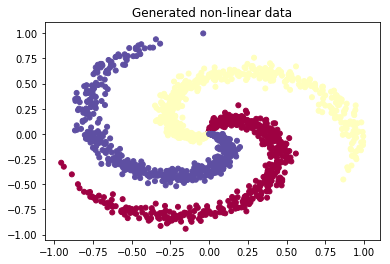

In [60]:
# Visualize data
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [61]:
torch.set_default_tensor_type(torch.FloatTensor)
torch.get_default_dtype()

torch.float32

In [62]:
# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [63]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


In [64]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [71]:
class MultilayerPerceptronModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultilayerPerceptronModel, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, apply_softmax=False):
        out = self.input_layer(x)
        out = self.relu(out)
        out = self.hidden_layer(out)

        if apply_softmax:
            out = nn.functional.softmax(out, dim=1)
        return out

In [72]:
# Initialize model
model = MultilayerPerceptronModel(input_dim=args.dimensions, hidden_dim=args.num_hidden_units, output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MultilayerPerceptronModel(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layer): Linear(in_features=100, out_features=3, bias=True)
  (relu): ReLU()
)>


In [73]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)

In [74]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 1.1058 | acc: 34.5%
epoch: 20 | loss: 0.4358 | acc: 72.1%
epoch: 40 | loss: 0.1456 | acc: 94.3%
epoch: 60 | loss: 0.0675 | acc: 98.0%
epoch: 80 | loss: 0.0441 | acc: 99.1%
epoch: 100 | loss: 0.0336 | acc: 99.5%
epoch: 120 | loss: 0.0281 | acc: 99.6%
epoch: 140 | loss: 0.0245 | acc: 99.6%
epoch: 160 | loss: 0.0217 | acc: 99.7%
epoch: 180 | loss: 0.0194 | acc: 99.7%


In [75]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [76]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.7%, test acc: 99.7%


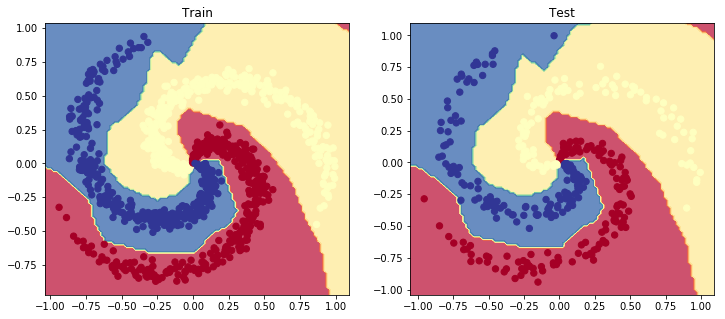

In [79]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      0.99      1.00       107
           2       0.99      1.00      1.00       134

   micro avg       1.00      1.00      1.00       375
   macro avg       1.00      1.00      1.00       375
weighted avg       1.00      1.00      1.00       375



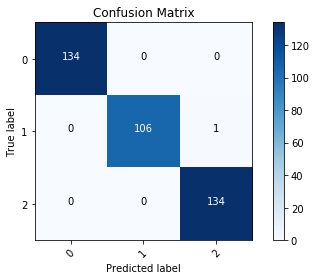

In [84]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))